In [62]:
import os
import sys
from pathlib import Path
# Make sure all code is in the PATH.
sys.path.append("../src/")

In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm

In [64]:
# Plot styling.
plt.style.use(["seaborn-white", "seaborn-paper"])
plt.rc("font", family="sans-serif")
sns.set_palette(["#9e0059", "#6da7de", "#ee266d", "#dee000", "#eb861e"])
sns.set_context("paper")

# ensure directory
Path("results/img/").mkdir(parents=True, exist_ok=True)

## Finished setup, start plotting

In [67]:
filename = "results/BILELIB19_oxy_sqrt_False_500000pairs_6min_signals_True_requirestruc_15i9949specific_delta_0mods.parquet"

# use filename to identify exported files
analysis_id = Path(filename).stem

similarities = pd.read_parquet(filename)
similarities.head(5)

,id1,id2,delta_mz,tanimoto,cos_score,cos_matched_intensity,cos_max_contribution,cos_n_greq_2p,cos_matches,mod_score,mod_matched_intensity,mod_max_contribution,mod_n_greq_2p,mod_matches,nl_score,nl_matched_intensity,nl_max_contribution,nl_n_greq_2p,nl_matches
0,CCMSLIB00006582143,CCMSLIB00006582536,15.995,0.9434,0.385219,0.699701,0.295515,2,49,0.759891,0.914379,0.299254,4,59,0.388615,0.654601,0.299254,2,22
1,CCMSLIB00006584957,CCMSLIB00006584488,15.995,0.9467,0.937016,0.924295,0.632445,3,538,0.974987,0.963916,0.632445,3,623,0.045735,0.480494,0.017492,0,415
2,CCMSLIB00006584184,CCMSLIB00006582702,15.995,0.9322,0.848506,0.913251,0.561022,2,95,0.942261,0.988703,0.561022,4,102,0.101276,0.712272,0.051093,2,61
3,CCMSLIB00006582603,CCMSLIB00006583887,15.995,0.8680,0.059368,0.813307,0.036360,1,73,0.670058,0.994983,0.428082,3,78,0.618268,0.974912,0.428082,2,66
4,CCMSLIB00006583607,CCMSLIB00005465228,15.995,0.8680,0.212186,0.826865,0.138137,2,544,0.773869,0.978033,0.398667,5,755,0.577487,0.813103,0.398667,3,548


In [68]:
# remove rows where all scores are 0
similarities = similarities[(similarities["cos_score"]>0) & (similarities["mod_score"]>0) & (similarities["nl_score"]>0)]
len(similarities)

9418

In [69]:
total = len(similarities)
stats = {
    'total': total,
    'cos higher': len(similarities[similarities["cos_score"]>similarities["nl_score"]])/ total,
    'nl higher': len(similarities[similarities["cos_score"]<similarities["nl_score"]])/ total
}
print(stats)

{'total': 9418, 'cos higher': 0.6139307708643024, 'nl higher': 0.3860692291356976}


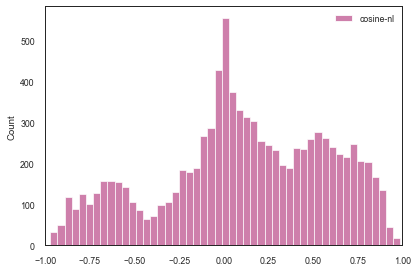

In [70]:
df = pd.DataFrame()
df['cosine-nl'] = similarities['cos_score'] - similarities['nl_score']
ax = sns.histplot(data=df, binwidth=0.04)
ax.set_xlim((-1,1))

plt.savefig("results/img/diff_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

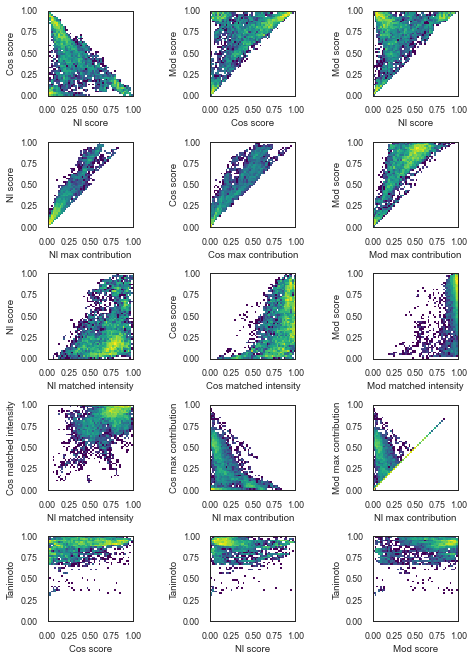

In [73]:
plots = [
        ["nl_score", "cos_score"],
        ["cos_score", "mod_score"],
        ["nl_score", "mod_score"],
        ["nl_max_contribution", "nl_score"],
        ["cos_max_contribution", "cos_score"],
        ["mod_max_contribution", "mod_score"],
        ["nl_matched_intensity", "nl_score"],
        ["cos_matched_intensity", "cos_score"],
        ["mod_matched_intensity", "mod_score"],
        ["nl_matched_intensity", "cos_matched_intensity"],
        ["nl_max_contribution", "cos_max_contribution"],
        ["nl_max_contribution", "mod_max_contribution"],
        ["cos_score", "tanimoto"],
        ["nl_score", "tanimoto"],
        ["mod_score", "tanimoto"],
    ]

fig, axes = plt.subplots(5, 3, figsize=(7, 15 / 1.618))

bins = 50
tick_locators = mticker.FixedLocator(np.arange(0, bins + 1, bins / 4))
tick_labels = np.asarray([f"{a:.2f}" for a in np.arange(0, 1.01, 0.25)])

for i, ax in enumerate(axes.flatten()):
    if i >= len(plots):
        break

    (xlabel, ylabel) = plots[i]
    hist, _, _ = np.histogram2d(
        similarities[xlabel],
        similarities[ylabel],
        bins=bins,
        range=[[0, 1], [0, 1]],
    )
    heatmap = sns.heatmap(
        np.rot90(hist),
        cmap="viridis",
        cbar=False,
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=ax,
        norm=LogNorm(),
    )
    ax.yaxis.set_major_locator(tick_locators)
    ax.set_yticklabels(tick_labels[::-1])
    ax.xaxis.set_major_locator(tick_locators)
    ax.set_xticklabels(tick_labels)
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
    ax.set_xlabel(xlabel.replace("_", " ").capitalize())
    ax.set_ylabel(ylabel.replace("_", " ").capitalize())


plt.tight_layout()

plt.savefig("results/img/score_contributions_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

xlabels = ["cos_n_greq_2p","nl_n_greq_2p","mod_n_greq_2p"]
max_x = similarities[["cos_n_greq_2p","nl_n_greq_2p","mod_n_greq_2p"]].max().max()
max_y = max(similarities[xlabel].value_counts()[0] for xlabel in xlabels) * 1.02

for i, ax in enumerate(axes.flatten()):
    xlabel = xlabels[i]

    hist = sns.histplot(data=similarities, x=xlabel, binwidth=1, ax= ax)
    # for _, spine in hist.spines.items():
    #     spine.set_visible(True)
    # ax.set_xlabel(xlabel.replace("_", " ").capitalize())
    # ax.set_ylabel(ylabel.replace("_", " ").capitalize())

    ax.set_xlim((0,max_x))
    ax.set_ylim((0,max_y))

plt.tight_layout()

plt.savefig("results/img/greater_2p_signals_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
g = sns.pairplot(similarities, kind="hist",
             vars=["cos_score", "nl_score", "mod_score", "cos_max_contribution", "nl_max_contribution"])
for axes in g.axes:
    for a in axes:
        a.set_xlim((0,1))
        a.set_ylim((0,1))

plt.savefig("results/img/pair_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()